CASO DE NEGOCIO:

El equipo comercial quiere realizar estrategias focalizadas para los sellers, pero en
este momento no existe una clasificación que permita identificar a aquellos que tienen
un buen perfil y son relevantes para el negocio. ¿Cómo podrías ayudar al equipo
comercial a identificar estos sellers?


En principio vamos a extraer a todos los vendedores activos de MercadoLibre, para luego pasar a un análisis e identificar aquellos relevantes para el negocio.

A modo de organizar la presentación, se puede observar el Indice del Notebook con sus partes.

# EXTRACCIÓN DE DATOS:

Creamos base con los vendedores y sus caracteristicas

In [ ]:
import requests
import pandas as pd
from dateutil import parser
import datetime

In [ ]:
pip install python-dateutil

In [ ]:
# lista de vendedores con sus caracteristicas.
vendedores = []

# Los paises donde está MELI
paises = requests.get('https://api.mercadolibre.com/sites#json')
paises = paises.json()

# Categorias de cada país:
contador = 0
for pais in paises:
    pais = pais["id"]

    cats = requests.get(f'https://api.mercadolibre.com/sites/{pais}/categories')
    cats = cats.json()
    contador += 1
    print("Leyendo ",contador," de 19 paises (",contador/19*100,"%)", " pais: ", pais)

    # Para cada categoria veo los items que tiene
    for cat in cats:
        cat_id = cat["id"]

        for offset in range (0,950,50):

            items = requests.get(f'https://api.mercadolibre.com/sites/{pais}/search?category={cat_id}&offset={offset}')
            items = items .json()

            # Para cada item extraigo el vendedor y hago un diccionario con los datos del vendedor que considero. Luego agrego esto a la lista vendedores
            for item in items["results"]:
                vendedor = {
                'id_vendedor': item['seller']['id'],
                'pais' : pais,
                'nombre': item['seller']['nickname'],
                'reputacion': item['seller']['seller_reputation']['level_id'],
                'clasificacion': item["seller"]["seller_reputation"]["power_seller_status"],
                'transacciones_canceladas': item["seller"]["seller_reputation"]["transactions"]["canceled"] ,
                'transacciones_completadas': item["seller"]["seller_reputation"]["transactions"]["completed"],
                'ventas_completadas_60dias':item["seller"]["seller_reputation"]["metrics"]["sales"]["completed"] ,
                'reclamos_60dias': item["seller"]["seller_reputation"]["metrics"]["claims"]["rate"],
                'tiempo_retraso_60dias': item["seller"]["seller_reputation"]["metrics"]["delayed_handling_time"]["value"]

                }

            vendedores.append(vendedor)




Leyendo  1  de 19 paises ( 5.263157894736842 %)  pais:  MCO
Leyendo  2  de 19 paises ( 10.526315789473683 %)  pais:  MHN
Leyendo  3  de 19 paises ( 15.789473684210526 %)  pais:  MPY
Leyendo  4  de 19 paises ( 21.052631578947366 %)  pais:  MRD
Leyendo  5  de 19 paises ( 26.31578947368421 %)  pais:  MLM
Leyendo  6  de 19 paises ( 31.57894736842105 %)  pais:  MNI
Leyendo  7  de 19 paises ( 36.84210526315789 %)  pais:  MPE
Leyendo  8  de 19 paises ( 42.10526315789473 %)  pais:  MLV
Leyendo  9  de 19 paises ( 47.368421052631575 %)  pais:  MLC
Leyendo  10  de 19 paises ( 52.63157894736842 %)  pais:  MLU
Leyendo  11  de 19 paises ( 57.89473684210527 %)  pais:  MSV
Leyendo  12  de 19 paises ( 63.1578947368421 %)  pais:  MGT
Leyendo  13  de 19 paises ( 68.42105263157895 %)  pais:  MEC
Leyendo  14  de 19 paises ( 73.68421052631578 %)  pais:  MLB
Leyendo  15  de 19 paises ( 78.94736842105263 %)  pais:  MCR
Leyendo  16  de 19 paises ( 84.21052631578947 %)  pais:  MCU
Leyendo  17  de 19 paises ( 89

In [ ]:
# Creo un df a partir de la lista de vendedores para mejor visualización
df = pd.DataFrame(vendedores)
# Como esta base carga los vendedores de cada item, abrá duplicados, los cuales quiero quitar y quedarme con sellers unicos:
df.drop_duplicates(subset='id_vendedor', inplace=True, ignore_index=True)

### Lo guardo en Drive

In [ ]:
import os # Para manipular archivos y directorios del Google Drive
# Conectamos con Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import os
# Me fijo los directorios asi se a cual entrar
os.chdir('/content/drive/MyDrive/MELI')
os.listdir()

['datos_meli', 'datos_meli2']

In [ ]:
df.to_csv('/content/drive/MyDrive/MELI/datos_meli')

## Metricas a mirar:
- Reputación (nivel)
- Clasificación del vendedor
- Transacciones canceladas
- Transacciones completadas
- Ventas completadas en los ultimos 60 días (da parametro de actividad)
- Reclamos en los últimos 60 días (en % de ventas)
- Tiempo de retraso en los 60 días
- Tiempo promedio de respuesta (no se puede obtener esta caracteristica directamente pero se puede calcular)


Observación de tiempo de retraso: "Solo contemplaremos aquellos vendedores que utilicen Mercado Envíos y tengan 10 o más ventas enviadas. El resto no se verá afectado por esta métrica y asumimos que sus ventas entregadas fuera de término es de 0." Uso los que tienen ti


## Agrego nueva caracteristica de tiempo promedio de respuesta

Agrego tiempo de respuesta promedio de cada vendedor.

Tiempo de respuesta a preguntas API: (https://developers.mercadolibre.com.ar/es_ar/gestiona-preguntas-respuestas)



In [ ]:
def tiempo_promedio_respuesta2 (id_vendedor, fila_index):

        # OBTENGO LOS TIEMPOS DE RESPUESTA PROMEDIO DE LOS VENDEDORES:

    # Cantidad de preguntas y tiempos de respuesta totales de cada vendedor
    t_resp_tot = 0
    cant_preg_tot = 0

    # ID del vendedor que deseas analizar
    #id_vendedor = 256324891

    # URL  para obtener los productos del vendedor
    url_productos = f'https://api.mercadolibre.com/sites/MLA/search?seller_id={id_vendedor}'

    # GET para obtener los productos del vendedor de la URL
    response_productos = requests.get(url_productos)


    # Verifico si la solicitud fue exitosa
    if response_productos.status_code == 200:
        data_productos = response_productos.json()

        # Itera a través de los productos del vendedor
        for producto in data_productos['results']:

            # Obtiene las preguntas de cada producto
            url_preguntas = f'https://api.mercadolibre.com/questions/search?item_id={producto["id"]}'
            response_preguntas = requests.get(url_preguntas)

            if response_preguntas.status_code == 200: # Chequeo que entre a URL
                data_preguntas = response_preguntas.json()

                # Calcula el tiempo de respuesta para este producto
                preguntas = data_preguntas['questions']
                if len(preguntas) > 0: # Chequeo que tenga preguntas
                    cant_preg_tot += len(preguntas) # Le voy sumando la cantidad de preguntas de cada producto a la cantidad de preguntas totales del vendedor
                    for pregunta in preguntas:
                        if pregunta["answer"] is not None: # Chequeo si tiene respuesta
                            t_resp_tot += (parser.isoparse(pregunta["answer"]["date_created"]) - parser.isoparse(pregunta["date_created"])).total_seconds()/60  # Diferencia de tiempo entre pregunta y respuesta en minutos. Se lo voy sumando al tiempo de respuesta del vendedor.

        print("Fila: ", fila_index, "completado: ", fila_index/4756*100,"%")

        # Calcula el tiempo de respuesta promedio general del vendedor
        if cant_preg_tot == 0:
            return "sin_preguntas"
        else:
            tiempo_respuesta_promedio = round(t_resp_tot / cant_preg_tot, 2) # Redondeo la respuesta a 2 decimales
            return tiempo_respuesta_promedio

In [ ]:
df['t_prom_resp'] = df.apply(lambda row: tiempo_promedio_respuesta2(row['id_vendedor'], row.name), axis=1)

Fila:  0 completado:  0.0 %
Fila:  1 completado:  0.021026072329688814 %
Fila:  2 completado:  0.04205214465937763 %
Fila:  3 completado:  0.06307821698906645 %
Fila:  4 completado:  0.08410428931875526 %
Fila:  5 completado:  0.10513036164844407 %
Fila:  6 completado:  0.1261564339781329 %
Fila:  7 completado:  0.1471825063078217 %
Fila:  8 completado:  0.16820857863751051 %
Fila:  9 completado:  0.18923465096719932 %
Fila:  10 completado:  0.21026072329688814 %
Fila:  11 completado:  0.23128679562657695 %
Fila:  12 completado:  0.2523128679562658 %
Fila:  13 completado:  0.27333894028595457 %
Fila:  14 completado:  0.2943650126156434 %
Fila:  15 completado:  0.3153910849453322 %
Fila:  16 completado:  0.33641715727502103 %
Fila:  17 completado:  0.35744322960470987 %
Fila:  18 completado:  0.37846930193439865 %
Fila:  19 completado:  0.3994953742640875 %
Fila:  20 completado:  0.42052144659377627 %
Fila:  21 completado:  0.4415475189234651 %
Fila:  22 completado:  0.4625735912531539 

### Vuelvo a guardarlo en Drive

In [ ]:
df.to_csv('/content/drive/MyDrive/MELI/datos_meli2')

## ¿Que otros campos o caracteristicas agregaría?
Se podrían sumar muchisimas más cosas: Monto vendido en cierto periodo (en usd por supuesto), Reclamos al vendedor, Calidad de publicación (Promedio de calidad de publicación en sus items), devoluciones (si hace o no),mensajeria post venta (si les da bola o no). Ni hablar de la cantidad de datos publicos (1000) que podrian ser más
  , etc
  
  ver metricas por paises ya q no todos tienen las mismas..

# ANALISIS EXPLORATORIO Y LIMPIEZA DE DATOS:

## LIMPIEZA:

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# Traigo los datos
df = pd.read_csv('/content/drive/MyDrive/MELI/datos_meli2')
df.drop("Unnamed: 0", axis=1, inplace=True) # Elimino la primer columna q se me habia creado con el indice

Lo primero que veo es la distribución de vendedores para cada país.

Dado que la idea de negocio es que el equipo comercial pueda tomar decisiones sobre los mejores vendedores de la plataforma, es necesario identificar a estos por país, dado que probablemente por cuestiones legales (o bien condiciones de cada país) no se puedan aplicar los mismos beneficios a unos que a otros y compararlos dentro de la misma bolsa.

Por ejemplo, quizas vendedores de brasil se llevan el ranking de vendedores por el mayor consumo del país, y no por eso dejas de tomar medidas en los mejores vendedores de otros paises.

Dicho esto, en este pequeño analisis, y tambien por cuestiones de tiempo (dado que no deja de ser una pequeña demostración del manejo de la herramienta para una entrevista), **me enfocaré en el caso de MELI ARGENTINA (MLA)**

De igual manera, las tecnicas de analisis exploratorio y clasificación de mejores vendedores son replicables para todos los paises.

In [ ]:
df["pais"].value_counts()

MLB    561
MLA    508
MCO    482
MLC    460
MLM    451
MLV    428
MPE    422
MLU    391
MEC    294
MCR    217
MRD    156
MGT    114
MBO     89
MPY     73
MPA     41
MNI     25
MHN     23
MSV     21
Name: pais, dtype: int64

In [ ]:
# Renombro al df con datos de Argentina:
df = df[df["pais"] == "MLA"]
df

In [ ]:
# Veo la información del df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 4207 to 4714
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_vendedor                508 non-null    int64  
 1   pais                       508 non-null    object 
 2   nombre                     508 non-null    object 
 3   reputacion                 461 non-null    object 
 4   clasificacion              417 non-null    object 
 5   transacciones_canceladas   508 non-null    int64  
 6   transacciones_completadas  508 non-null    int64  
 7   ventas_completadas_60dias  508 non-null    int64  
 8   reclamos_60dias            508 non-null    float64
 9   tiempo_retraso_60dias      508 non-null    int64  
 10  t_prom_resp                508 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 47.6+ KB


In [ ]:
# Los valores nulos no son tantos, puedo sacarlos (me quedo con un 82% de los datos):
df.isnull().sum()

id_vendedor                   0
pais                          0
nombre                        0
reputacion                   47
clasificacion                91
transacciones_canceladas      0
transacciones_completadas     0
ventas_completadas_60dias     0
reclamos_60dias               0
tiempo_retraso_60dias         0
t_prom_resp                   0
dtype: int64

In [ ]:
# Saco los nulos:
df.dropna(inplace= True)

In [ ]:
df.isnull().sum()

id_vendedor                  0
pais                         0
nombre                       0
reputacion                   0
clasificacion                0
transacciones_canceladas     0
transacciones_completadas    0
ventas_completadas_60dias    0
reclamos_60dias              0
tiempo_retraso_60dias        0
t_prom_resp                  0
dtype: int64

**Paso los datos a números para poder compararlos:**

In [ ]:
# Paso a número el campo "t_prom_resp":
df["t_prom_resp"] = df["t_prom_resp"].astype(float)

In [ ]:
# Veo que en "clasificación" tengo categorias, las convierto a números. Luego hago lo mismo con el campo "reputacion"
df["clasificacion"].value_counts()

platinum    347
gold         42
silver       28
Name: clasificacion, dtype: int64

In [ ]:
# Convierto las categorias de "clasificacion" a números:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['clasificacion_num'] = label_encoder.fit_transform(df['clasificacion']) #creo columna clasificacion_num

In [ ]:
# En el campo "reputacion" veo que solo tengo una sola clasificación (esto es por la poca cantidad de vendedores que tengo).
# Por lo cual al tener una sola no me sirve de nada, borro el campo
df["reputacion"].value_counts()

5_green    417
Name: reputacion, dtype: int64

In [ ]:
# Borro el campo clasificación ya que tengo solo una:
df.drop("reputacion", axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 4207 to 4714
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_vendedor                417 non-null    int64  
 1   pais                       417 non-null    object 
 2   nombre                     417 non-null    object 
 3   clasificacion              417 non-null    object 
 4   transacciones_canceladas   417 non-null    int64  
 5   transacciones_completadas  417 non-null    int64  
 6   ventas_completadas_60dias  417 non-null    int64  
 7   reclamos_60dias            417 non-null    float64
 8   tiempo_retraso_60dias      417 non-null    int64  
 9   t_prom_resp                417 non-null    float64
 10  clasificacion_num          417 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 39.1+ KB


## EXPLORACIÓN:

Si bien ya estuvimos explorando, veo un poco mas las caracteristicas y relaciones

In [ ]:
# Cro df2 con campos númericos para ver correlaciones
df2 = df[["id_vendedor","transacciones_canceladas","transacciones_completadas","ventas_completadas_60dias","reclamos_60dias","tiempo_retraso_60dias","t_prom_resp","clasificacion_num"]]

In [ ]:
df.describe()

,id_vendedor,transacciones_canceladas,transacciones_completadas,ventas_completadas_60dias,reclamos_60dias,tiempo_retraso_60dias,t_prom_resp,clasificacion_num
count,4.170000e+02,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,2.738005e+08,2305.175060,42109.460432,7623.695444,0.002740,56.892086,266.960336,0.966427
std,2.647824e+08,5331.834277,90775.517398,16415.673253,0.002413,175.132204,375.119221,0.408827
min,6.805150e+05,2.000000,71.000000,58.000000,0.000000,0.000000,1.190000,0.000000
25%,8.553554e+07,212.000000,3675.000000,807.000000,0.000700,1.000000,49.040000,1.000000
50%,1.871404e+08,658.000000,12015.000000,2243.000000,0.002200,8.000000,126.480000,1.000000
75%,3.856354e+08,2129.000000,38664.000000,7321.000000,0.004300,31.000000,322.330000,1.000000
max,1.369572e+09,61086.000000,934310.000000,170589.000000,0.009900,1857.000000,2866.080000,2.000000


In [ ]:
corr_matrix = df2.corr()

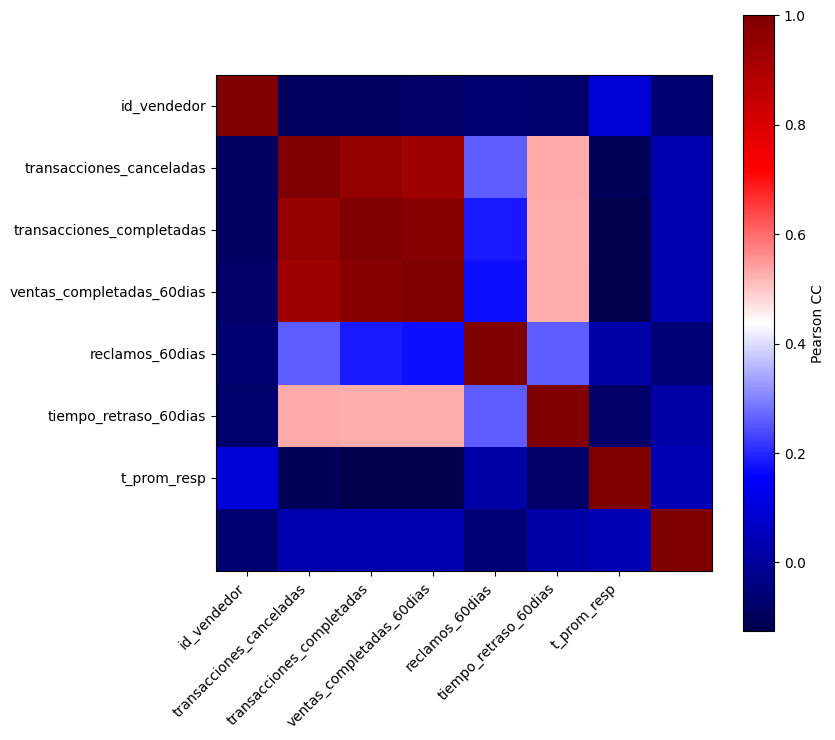

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(corr_matrix, cmap='seismic')

# Definir las marcaciones
xt = plt.xticks(np.arange(7), df2.columns[:-1], rotation=45, ha='right', va='top')
yt = plt.yticks(np.arange(7), df2.columns[:-1], rotation=0, ha='right', va='center')

# Definir la barra de colores
plt.colorbar(label='Pearson CC')

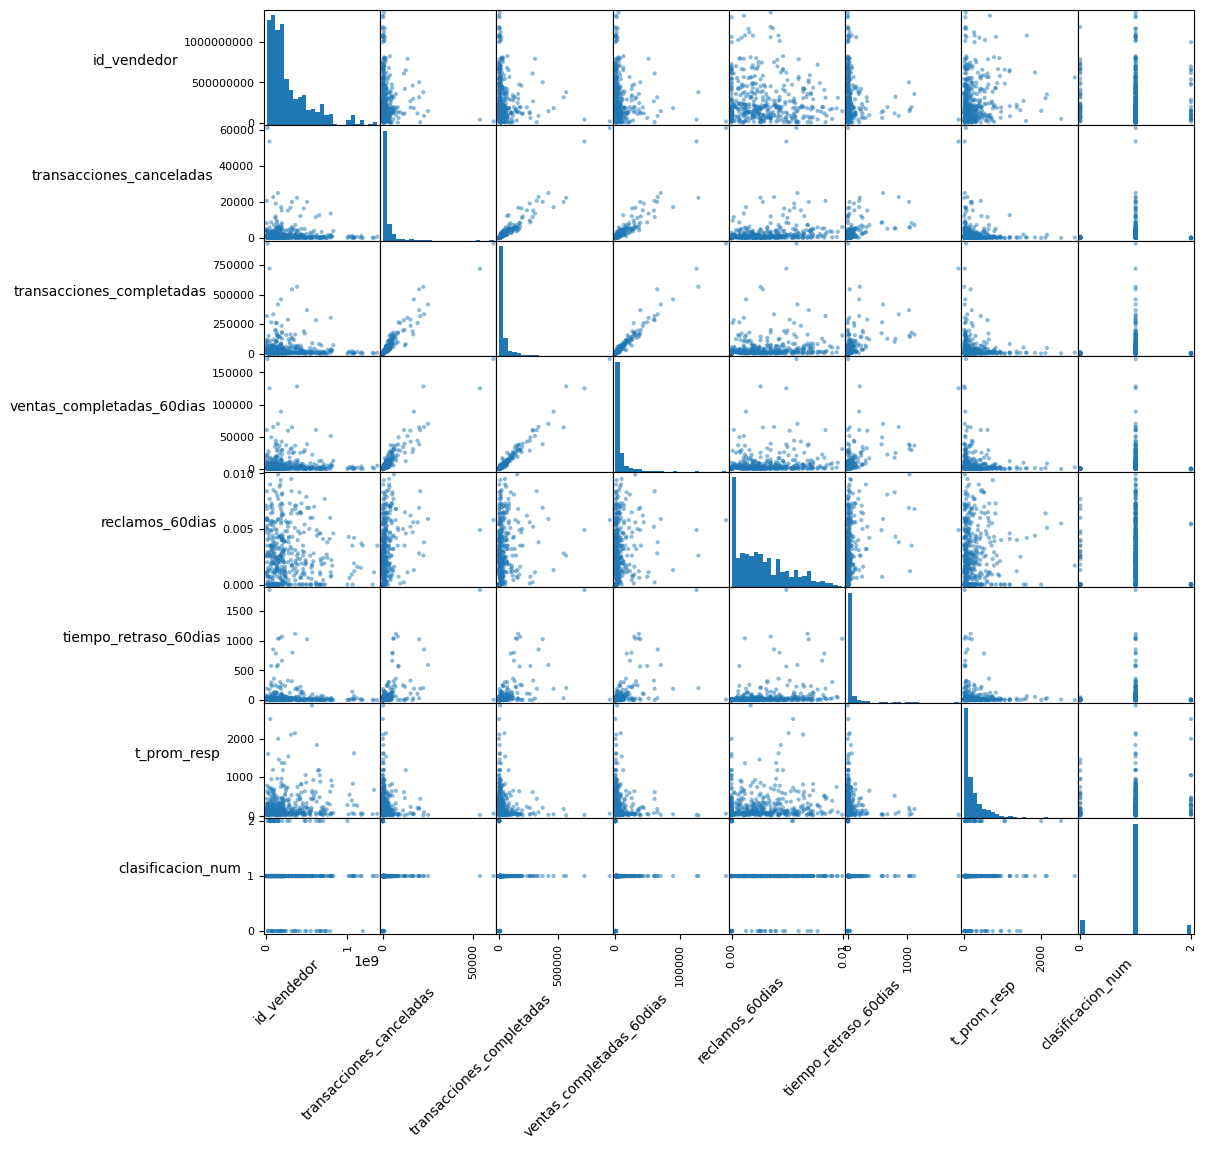

In [ ]:
axes = pd.plotting.scatter_matrix(df2.iloc[:], figsize=(12, 12), alpha=0.5, hist_kwds={'bins': 25})

# Roto las etiquetas (puramente estético)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

Aca hay muchas cosas que se pueden decir, pero resumiendo se puede ver que a mayor cantidad de ventas completas, menor tiempo de respuesta, menor retraso, y menos reclamos. Esto se debe probablemente a que un cliente mientras más ventas tiene, a su vez más experiencia en la página y más dedicación, por lo cual aumenta su calidad de servicio ofrecido.

De todas formas hay un sesgo dado los pocos datos.

Veo tambien que la distribución de "tiempo_retraso_60dias" tiene muchos valores en EXACTAMENTE cero (cosa que es casi imposible que sea exactamente cero), esto se debe a que, como describe la API, se le pone tiempo de retraso cero a aquellos vendedores que no usan mercadoenvios para sus ventas.

Como yo quiero quedarme con los mejores vendedores que favorecen a la empresa, me quedaré con los vendedores que usen mercadoenvio para sus ventas (aquellos con tiempo mayor a cero) ya que considero que usar esta forma de envios permite a mercadolibre tener un control sobre envios (y el negocio en si) y a su vez generar tambien un ingreso por ese lado, por lo cual consideraré que si el equipo de comercial toma una acción para beneficiar a los vendedores, deben ser premiados aquellos que opten por este método de envio.

In [ ]:
len(df[df['tiempo_retraso_60dias'] > 0]) # Igual a cero hay  75, mayor a cero hay 342

342

In [ ]:
# Redefino el df con estos vendedores:
df = df[df['tiempo_retraso_60dias'] > 0]

## CLASIFICACIÓN DE SELLERS:

A partir de la limpieza y analisis de datos, clasificaremos a los vendedores a traves de un modelo de aprendizaje no supervisado (K-means), luego generaremos un ranking de los mejores vendedores en base a metricas.

In [ ]:
from sklearn.preprocessing import StandardScaler


# Selecciono características relevantes
features = ['transacciones_canceladas', 'transacciones_completadas', 'ventas_completadas_60dias',
            'reclamos_60dias', 'tiempo_retraso_60dias', 't_prom_resp','clasificacion_num' ]

X = df[features]

# Estandarizo las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans

# Aplico K-Means y me fijo que K aplicar por inercia y siluetas:


kmeans_para_varios_k = [KMeans(n_clusters=k, n_init=20).fit(X)
                        for k in range(1, 10)]

inercias = [model.inertia_ for model in kmeans_para_varios_k]

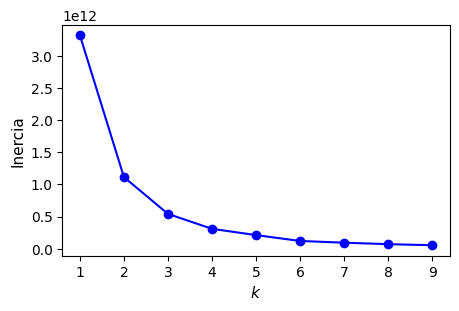

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, 10), inercias, "bo-")

plt.xlabel("$k$", fontsize=11)
plt.ylabel("Inercia", fontsize=11)

plt.show()

In [ ]:
# Analisis de siluetas:

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_para_varios_k[1:]]

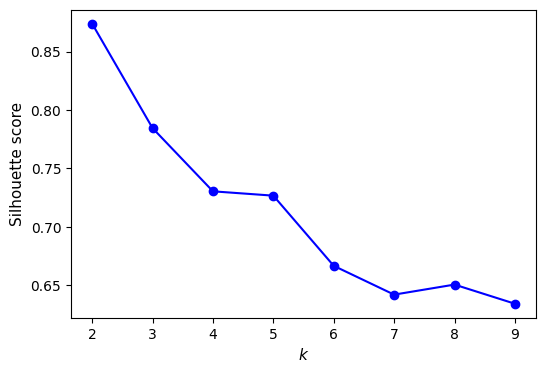

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=11)
plt.ylabel("Silhouette score", fontsize=11)
plt.show()

Observando el analisis de inercia y siluetas, concluimos que nos conviene clasificar en 3 grupos, es decir, k=3

In [ ]:
k_model = kmeans_para_varios_k[2] # Osea tomo el que tiene k = 3

In [ ]:
df['cluster'] = k_model.fit_predict(X_scaled) # Le agrego columna con el numero de cluster

In [ ]:
# Creo ranking dentro de cada grupo en función de ventas completadas (quizas se podría hace por valor de $ si tuviera el dato)
ranked_df = df.groupby('cluster').apply(lambda x: x.sort_values(by='ventas_completadas_60dias', ascending=False))

In [ ]:
ranked_df["cluster"].value_counts()

0    290
2     29
1     23
Name: cluster, dtype: int64

Para cada grupo clasificado veo las caracteristicas:

In [ ]:
ranked_df[ranked_df["cluster"]==0].describe()

,id_vendedor,transacciones_canceladas,transacciones_completadas,ventas_completadas_60dias,reclamos_60dias,tiempo_retraso_60dias,t_prom_resp,clasificacion_num,cluster
count,2.900000e+02,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.0
mean,2.736239e+08,1676.596552,30390.258621,5598.686207,0.003024,34.744828,284.339000,1.044828,0.0
std,2.658481e+08,2142.178187,36302.270277,6766.933515,0.002340,57.741193,381.364797,0.207283,0.0
min,6.805150e+05,10.000000,183.000000,64.000000,0.000000,1.000000,5.060000,1.000000,0.0
25%,8.289246e+07,343.250000,6288.500000,1312.250000,0.001100,4.000000,57.172500,1.000000,0.0
50%,1.872669e+08,905.500000,16034.500000,3050.500000,0.002550,12.000000,134.580000,1.000000,0.0
75%,3.899607e+08,2165.250000,40672.000000,7549.750000,0.004475,37.750000,339.835000,1.000000,0.0
max,1.329897e+09,16805.000000,200500.000000,39272.000000,0.009500,361.000000,2514.570000,2.000000,0.0


In [ ]:
ranked_df[ranked_df["cluster"]==1].describe()

,id_vendedor,transacciones_canceladas,transacciones_completadas,ventas_completadas_60dias,reclamos_60dias,tiempo_retraso_60dias,t_prom_resp,clasificacion_num,cluster
count,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0
mean,2.082337e+08,17297.565217,320284.956522,57787.260870,0.004922,583.608696,117.784348,1.0,1.0
std,1.783936e+08,14241.142194,209288.109672,37955.325746,0.002547,474.691167,132.953196,0.0,0.0
min,4.641264e+06,5246.000000,99684.000000,17597.000000,0.000700,7.000000,6.300000,1.0,1.0
25%,1.110208e+08,7757.000000,166755.000000,35239.500000,0.003150,191.500000,31.115000,1.0,1.0
50%,1.623216e+08,15244.000000,265008.000000,43958.000000,0.005000,576.000000,50.610000,1.0,1.0
75%,2.901447e+08,20366.500000,392417.500000,64978.000000,0.006500,940.000000,171.550000,1.0,1.0
max,7.938865e+08,61086.000000,934310.000000,170589.000000,0.009900,1857.000000,518.230000,1.0,1.0


In [ ]:
ranked_df[ranked_df["cluster"]==2].describe()

,id_vendedor,transacciones_canceladas,transacciones_completadas,ventas_completadas_60dias,reclamos_60dias,tiempo_retraso_60dias,t_prom_resp,clasificacion_num,cluster
count,2.900000e+01,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0,29.0
mean,3.090853e+08,140.034483,2540.413793,385.724138,0.002107,7.758621,327.627931,0.0,2.0
std,2.819886e+08,93.646174,2074.034311,156.992697,0.002200,9.474233,408.906802,0.0,0.0
min,1.696747e+07,14.000000,269.000000,232.000000,0.000000,1.000000,1.190000,0.0,2.0
25%,1.217061e+08,66.000000,1468.000000,274.000000,0.000000,2.000000,66.130000,0.0,2.0
50%,2.084235e+08,119.000000,1930.000000,350.000000,0.002300,6.000000,141.220000,0.0,2.0
75%,3.833952e+08,187.000000,3185.000000,404.000000,0.003500,8.000000,533.280000,0.0,2.0
max,1.190547e+09,426.000000,11129.000000,828.000000,0.007100,44.000000,1459.220000,0.0,2.0


Veo que el promedio de ventas completadas más alto se lo lleva el grupo 1, luego le sigue el 0 y último el 2, por lo cual podemos definir a estos grupos como:

- Grupo 0 = Vendedores medios
- Grupo 1 = Mejores Vendedores
- Grupo 2 = Vendedores con menor nivel


Dicho esto, presento listado de los mejores vendedores del grupo de mejores vendedores (grupo 1), el cual se le envia al equipo comercial:

In [ ]:
ranked_df[ranked_df["cluster"]==1][["id_vendedor","nombre","ventas_completadas_60dias"]]

id_vendedor              nombre  ventas_completadas_60dias
cluster                                                                 
1       4445     13647702            LIBERCAM                     170589
        4324    377840555      FARMACIA SELMA                     128101
        4659     37133205           SALES COM                     125233
        4245    179907718           ECOMODICO                      89027
        4405    142125695          TECNOFAST_                      70137
        4538     83417473       PINTURERIASMM                      65340
        4656    314805333          DD2REGALOS                      64616
        4461      4641264          PHOTOSTORE                      60551
        4228    265484143             PIDEWEB                      59468
        4253    793886457  MEJORPRECIO.COM.AR                      51345
        4244     57995397         CAPSULANDIA                      49238
        4428    114457637       ELECTRO POINT                      43958
        4651    188316739        ELECTRO LAND                      42479
        4578    501615772  BEAUTIFULL REGALOS                      38501
        4601    128411524  KINDERLAND OFICIAL                      38301
        4339    355576322       MORA PAÑALERA                      36386
        4336    162321615         FARMASERVIS                      36192
        4460    107584006          LEVYSBAZAR                      34287
        4262    141966155        CATYCAN_S.A.                      30863
        4328    191047873        PEDIDOSFARMA                      29305
        4662    320396604           OPENFARMA                      25010
        4698    191914203            G.UTOPIA                      22583
        4323    114882315          LAPANALERA                      17597

Se podrían implementar otros modelos como por ejemplo DBSCAN para comparar y elegir con cual quedarse. Nuevamente recordar que este caso es "ilustrativo"